# Modeling

This notebook uses a wide variety of modeling algorithms for a binary classification problem. It reads a file created from a feature selection process that has a reasonably small number of good variables, and we know their order of multivariate importance because we used a proper wrapper method. We can explore # input variables, model algorithms and tune model hyperparameters. At the end we can select our favorite algorithm, run it again and build the final model performace score percentile tables.

Here we call the larger fraction population the goods and the smaller fraction the bads. This notebook was originally
written for fraud detection but can be used for any binary classification. It uses detection rate as an appropriate measure of goodness.

Rather than use a built-in CV, we do a "manual CV" by running each model multiple (nitermax) times and average the performance on the training (trn), testing (tst) and out of time (oot) data sets.

Some of the ML algorithms are very fast and some are slow. Feel free to comment out any cells/models you want. At the bottom of the notebook you can select your final model/hyperparameters to run one time only and then make the business perfoemance tables for that final model.

Things to add: better calculation of FDR@3% when building a model using sampled training data. Right now I just approximate it by using the entire population trntst for a model built with sampled data.

In [1]:
from datetime import datetime
start_time = datetime.now()

import pandas as pd
import xgboost as xgb
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
import gc
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
%%time
vars = pd.read_csv('final_variables.csv')
print(vars.shape)
vars.head()

(96397, 22)
CPU times: user 86.7 ms, sys: 13.6 ms, total: 100 ms
Wall time: 104 ms


,card_merch_total_14,card_zip3_max_14,Card_Merchdesc_count_7,Cardnum_avg_14,card_zip_max_0,card_merch_avg_0,Card_Merchnum_desc_max_0,card_zip3_med_3,Card_Merchnum_desc_avg_0,Card_Merchdesc_avg_0,...,Card_Merchnum_desc_med_1,Card_Merchnum_desc_avg_1,Card_Merchdesc_med_3,Card_Merchdesc_med_0,Card_Merchnum_desc_med_0,Card_Merchdesc_avg_3,Card_Merchdesc_avg_1,card_merch_avg_3,Recnum,Fraud
0,3.62,3.62,1,3.62,3.62,3.62,3.62,3.62,3.62,3.62,...,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,1,0
1,31.42,31.42,1,31.42,31.42,31.42,31.42,31.42,31.42,31.42,...,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,2,0
2,178.49,178.49,1,178.49,178.49,178.49,178.49,178.49,178.49,178.49,...,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,3,0
3,3.62,3.62,1,3.62,3.62,3.62,3.62,3.62,3.62,3.62,...,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,4,0
4,7.24,3.62,2,3.62,3.62,3.62,3.62,3.62,3.62,3.62,...,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,5,0


In [3]:
# set the number of variables desired here, and set the names of the y and record number properly
NVARS = 10

#vars.rename(columns={'record':'Recnum'},inplace=True)
#vars.rename(columns={'fraud_label':'Fraud'},inplace=True)
numvars = min(NVARS,len(vars)-2)
final_vars_list = ['Recnum','Fraud']
for i in range(numvars):
    final_vars_list.append(vars.columns[i])
    
final_vars_list

['Recnum',
 'Fraud',
 'card_merch_total_14',
 'card_zip3_max_14',
 'Card_Merchdesc_count_7',
 'Cardnum_avg_14',
 'card_zip_max_0',
 'card_merch_avg_0',
 'Card_Merchnum_desc_max_0',
 'card_zip3_med_3',
 'Card_Merchnum_desc_avg_0',
 'Card_Merchdesc_avg_0']

In [4]:
vars = vars.filter(final_vars_list,axis=1)
vars.head()

,Recnum,Fraud,card_merch_total_14,card_zip3_max_14,Card_Merchdesc_count_7,Cardnum_avg_14,card_zip_max_0,card_merch_avg_0,Card_Merchnum_desc_max_0,card_zip3_med_3,Card_Merchnum_desc_avg_0,Card_Merchdesc_avg_0
0,1,0,3.62,3.62,1,3.62,3.62,3.62,3.62,3.62,3.62,3.62
1,2,0,31.42,31.42,1,31.42,31.42,31.42,31.42,31.42,31.42,31.42
2,3,0,178.49,178.49,1,178.49,178.49,178.49,178.49,178.49,178.49,178.49
3,4,0,3.62,3.62,1,3.62,3.62,3.62,3.62,3.62,3.62,3.62
4,5,0,7.24,3.62,2,3.62,3.62,3.62,3.62,3.62,3.62,3.62


In [5]:
vars.shape

(96397, 12)

In [6]:
vars['Fraud'].sum()

1059

In [7]:
vars.head(10)

,Recnum,Fraud,card_merch_total_14,card_zip3_max_14,Card_Merchdesc_count_7,Cardnum_avg_14,card_zip_max_0,card_merch_avg_0,Card_Merchnum_desc_max_0,card_zip3_med_3,Card_Merchnum_desc_avg_0,Card_Merchdesc_avg_0
0,1,0,3.62,3.62,1,3.62,3.62,3.62,3.62,3.62,3.62,3.62
1,2,0,31.42,31.42,1,31.42,31.42,31.42,31.42,31.42,31.42,31.42
2,3,0,178.49,178.49,1,178.49,178.49,178.49,178.49,178.49,178.49,178.49
3,4,0,3.62,3.62,1,3.62,3.62,3.62,3.62,3.62,3.62,3.62
4,5,0,7.24,3.62,2,3.62,3.62,3.62,3.62,3.62,3.62,3.62
5,6,0,3.67,3.67,1,3.67,3.67,3.67,3.67,3.67,3.67,3.67
6,7,0,3.62,3.62,1,3.62,3.62,3.62,3.62,3.62,3.62,3.62
7,8,0,230.32,230.32,1,230.32,230.32,230.32,230.32,230.32,230.32,230.32
8,9,0,62.11,62.11,1,62.11,62.11,62.11,62.11,62.11,62.11,62.11
9,10,0,10.86,3.62,3,3.62,3.62,3.62,3.62,3.62,3.62,3.62


In [8]:
vars.shape

(96397, 12)

In [9]:
vars.describe()

,Recnum,Fraud,card_merch_total_14,card_zip3_max_14,Card_Merchdesc_count_7,Cardnum_avg_14,card_zip_max_0,card_merch_avg_0,Card_Merchnum_desc_max_0,card_zip3_med_3,Card_Merchnum_desc_avg_0,Card_Merchdesc_avg_0
count,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000
mean,48365.481820,0.010986,769.967286,529.353162,2.096186,396.993474,422.732816,395.812357,420.780131,391.980027,395.808621,395.692626
std,27945.003883,0.104236,4168.214517,1086.568630,3.836431,522.916559,936.565980,796.953627,935.362747,785.037728,796.983198,795.360037
min,1.000000,0.000000,0.010000,0.010000,1.000000,0.140000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
25%,24154.000000,0.000000,77.000000,57.190000,1.000000,119.940000,37.420000,34.990000,36.000000,37.190000,35.000000,35.000000
50%,48365.000000,0.000000,236.920000,212.660000,1.000000,279.450000,149.000000,141.000000,147.790000,145.950000,141.075000,141.300000
75%,72578.000000,0.000000,676.860000,609.000000,2.000000,502.776667,454.000000,435.300000,450.620000,433.600000,435.190000,435.300000
max,96753.000000,1.000000,306633.410000,47900.000000,90.000000,25500.000000,47900.000000,28392.840000,47900.000000,28392.840000,28392.840000,28392.840000


In [10]:
record_save = vars['Recnum']
Y_save = pd.DataFrame(vars.loc[:,'Fraud'])
Y_save.head()

,Fraud
0,0
1,0
2,0
3,0
4,0


## Scale and truncate field values

In [11]:
X_no_scaling = vars.drop(columns = ['Recnum','Fraud'])
X_no_scaling.describe()

,card_merch_total_14,card_zip3_max_14,Card_Merchdesc_count_7,Cardnum_avg_14,card_zip_max_0,card_merch_avg_0,Card_Merchnum_desc_max_0,card_zip3_med_3,Card_Merchnum_desc_avg_0,Card_Merchdesc_avg_0
count,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000
mean,769.967286,529.353162,2.096186,396.993474,422.732816,395.812357,420.780131,391.980027,395.808621,395.692626
std,4168.214517,1086.568630,3.836431,522.916559,936.565980,796.953627,935.362747,785.037728,796.983198,795.360037
min,0.010000,0.010000,1.000000,0.140000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
25%,77.000000,57.190000,1.000000,119.940000,37.420000,34.990000,36.000000,37.190000,35.000000,35.000000
50%,236.920000,212.660000,1.000000,279.450000,149.000000,141.000000,147.790000,145.950000,141.075000,141.300000
75%,676.860000,609.000000,2.000000,502.776667,454.000000,435.300000,450.620000,433.600000,435.190000,435.300000
max,306633.410000,47900.000000,90.000000,25500.000000,47900.000000,28392.840000,47900.000000,28392.840000,28392.840000,28392.840000


In [12]:
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()

In [13]:
# use this to cap variables. For some problems it helps
Clip = 10

In [14]:
# push in any outlier values, then rescale
X.clip(-1*Clip,Clip,inplace=True)

# Now redo the zscaling after clipping

X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()
X.describe()




,card_merch_total_14,card_zip3_max_14,Card_Merchdesc_count_7,Cardnum_avg_14,card_zip_max_0,card_merch_avg_0,Card_Merchnum_desc_max_0,card_zip3_med_3,Card_Merchnum_desc_avg_0,Card_Merchdesc_avg_0
count,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04
mean,2.034397e-17,-6.663388e-17,2.712530e-17,-1.769041e-18,-2.800982e-17,-9.670758e-17,3.302210e-17,-8.167073e-17,8.845206e-19,-5.778868e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.847211e-01,-4.871696e-01,-2.857305e-01,-7.589231e-01,-4.513540e-01,-4.966442e-01,-4.498470e-01,-4.993009e-01,-4.966210e-01,-4.974887e-01
25%,-1.662504e-01,-4.345452e-01,-2.857305e-01,-5.298235e-01,-4.114102e-01,-4.527520e-01,-4.113700e-01,-4.519401e-01,-4.527180e-01,-4.534960e-01
50%,-1.278838e-01,-2.914617e-01,-2.857305e-01,-2.247844e-01,-2.922729e-01,-3.197330e-01,-2.918548e-01,-3.133990e-01,-3.196223e-01,-3.198459e-01
75%,-2.233745e-02,7.330125e-02,-2.507162e-02,2.022946e-01,3.338492e-02,4.954823e-02,3.190192e-02,5.301653e-02,4.941306e-02,4.979804e-02
max,7.337997e+01,4.359655e+01,2.291291e+01,4.800576e+01,5.069292e+01,3.513006e+01,5.076022e+01,3.566817e+01,3.512876e+01,3.520060e+01


In [15]:
# separate data into modeling (traintest) and out of time. Here I'm using the record number to do this separation.
# you need to change this oot record number to whatever is appropriate for your data
oot_recnum=84300
X_trntst = X[0:oot_recnum]
Y_trntst = Y_save[0:oot_recnum]
X_oot = X[oot_recnum:]
Y_oot = Y_save[oot_recnum:]



## Explore regularization

Solve a linear regression with ridge and lasso regularization and watch how the variable weights evolve with the regularization strength

In [16]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV 
from sklearn.metrics import mean_squared_error




In [17]:
alphas = 10**np.linspace(2,9,30)*0.5

In [18]:
X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)


In [19]:
ridge = Ridge()
coefs = []
for a in alphas: 
    ridge.set_params(alpha=a) 
    ridge.fit(X_trn,Y_trn.values.ravel()) 
    coefs.append(ridge.coef_) 
np.shape(coefs)

(30, 10)

CPU times: user 201 ms, sys: 31.7 ms, total: 233 ms
Wall time: 240 ms


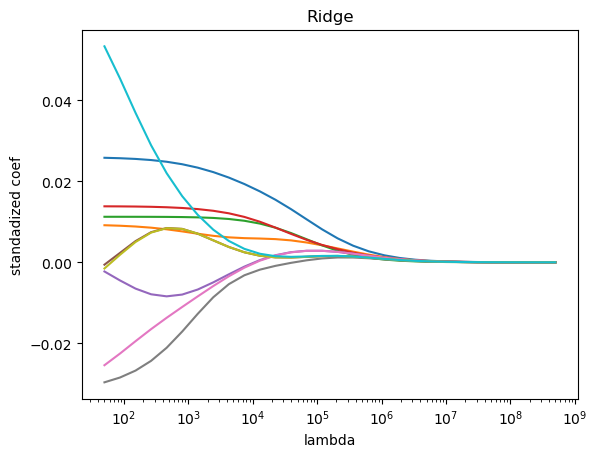

In [20]:
%%time
%matplotlib inline
ax = plt.gca() # Get the current Axes instance
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('lambda') 
plt.ylabel('standadized coef') 
plt.title('Ridge')
plt.savefig('ridge.png')

In [21]:
# alphas = 10**np.linspace(-5,0,30)*0.5

In [22]:
# %%time
# # sometimes this cell takes a long time
# lasso = Lasso(max_iter=10000) 
# coefs = [] 
# for a in alphas: 
#     lasso.set_params(alpha=a) 
#     lasso.fit(X_trn,Y_trn.values.ravel()) 
#     coefs.append(lasso.coef_) 
# # print('Shape:',np.shape(coefs)
# print('Selected Features:', list(vars.columns[np.where(lasso.coef_!=0)[0]]))

In [23]:
# %matplotlib inline
# ax = plt.gca() # Get the current Axes instance 
# ax.plot(alphas, coefs)
# ax.set_xscale('log')
# plt.xlabel('lambda')
# plt.ylabel('standerdized coef') 
# plt.title('Lasso')
# plt.legend()
# plt.savefig('lasso.png')

## Look at PCA

In [24]:
# len(X_trntst.columns)

In [25]:
# X_trntst_save = X_trntst.copy()

In [26]:
# pca = PCA(n_components = .999, svd_solver = 'full')
# pca.fit(X_trntst)
# # plt.plot(pca.explained_variance_ratio_)
# plt.xlabel('Number of components minus 1')
# plt.ylabel('PC variance')
# plt.xticks(np.arange(0, len(X_trntst.columns), step=2))
# plt.axhline(y=0,xmin=0,xmax=len(X_trntst.columns))
# X_trntst = X_trntst_save.copy()

In [27]:
# # We look at the above picture, select how many PCs we want to keep, and then redo the PCA with just this many PCs
# pca = PCA(n_components = 6, svd_solver = 'full')
# princ_comps = pca.fit_transform(X_trntst)
# X_trntst_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
# X_trntst_pca.head()

In [28]:
# princ_comps = pca.transform(X_oot)
# X_oot_orig_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)],index=X_oot.index)
# X_oot_orig_pca.head()




In [29]:
#X_trntst.describe()

In [30]:
#X_oot_orig_pca.describe()

In [31]:
# # zscale the PCs
# mean = X_trntst_pca.mean()
# stdev = X_trntst_pca.std()
# X_trntst_pca = (X_trntst_pca - mean)/stdev
# X_oot_orig_pca = (X_oot_orig_pca - mean)/stdev

In [32]:
# X_trntst_pca.describe()

In [33]:
# X_oot_orig_pca.describe()

In [34]:
# X_trntst_pca.shape

In [35]:
# X_oot_orig_pca.shape

## Subsample the larger class if desired

In [36]:
# set the ratio of goods to bads that you would like. This next line is the ratio of goods to bads that you want for modeling
sample_ratio_desired = 1

temp = X_trntst.copy()
temp['Fraud'] = Y_trntst['Fraud']
temp.head()
goods = temp[temp['Fraud']==0]
bads = temp[temp['Fraud']==1]
actual_bad_fraction = len(bads)/len(temp)
actual_good_fraction = 1 - actual_bad_fraction
print(actual_bad_fraction)
fraction = sample_ratio_desired * actual_bad_fraction
goods_sampled = goods.sample(frac = fraction)
all_sampled = pd.concat([goods_sampled,bads])
all_sampled.sort_index(inplace=True)
Y_trntst_sampled = pd.DataFrame(all_sampled['Fraud'])
X_trntst_sampled = all_sampled.drop(columns=['Fraud'])
del [temp,goods,bads,all_sampled]
gc.collect()
print(X_trntst_sampled.shape,len(Y_trntst_sampled))




0.01043890865954923
(1751, 10) 1751


In [37]:
niter = 0
nitermax = 10
X_oot_orig = X_oot.copy()
pd.options.mode.chained_assignment = None  # default='warn'

## Models

You can comment in/out any of these model cells and just explore one model type. You can also just rerun that single cell multiple times (hit shift-enter on that cell) as you manually explore different model hyperparameters.

In [38]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [39]:
import warnings
warnings.filterwarnings('ignore')

In [40]:
Modeling_output = pd.DataFrame(columns=['Model','Trn','Tst','OOT'],index=range(1000))
counter = 0
model_counter = 0



In [41]:
%%time
# Logistic regression

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    model = LogisticRegression(max_iter=1000,C=0.1,solver ='lbfgs',penalty='l2')
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['log reg',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.5976627712854758 0.5800711743772242 0.3743016759776536
1 0.5700483091787439 0.640926640926641 0.37988826815642457
2 0.5767366720516963 0.6360153256704981 0.3743016759776536
3 0.5773026315789473 0.6139705882352942 0.3743016759776536
4 0.594551282051282 0.58984375 0.37988826815642457
5 0.6123417721518988 0.5282258064516129 0.3743016759776536
6 0.6111111111111112 0.5524475524475524 0.3854748603351955
7 0.5914149443561209 0.5816733067729084 0.37988826815642457
8 0.5768595041322314 0.6181818181818182 0.3743016759776536
9 0.5952 0.5843137254901961 0.3687150837988827
trn    0.590323
tst    0.592567
oot    0.376536
dtype: float64
CPU times: user 1.08 s, sys: 102 ms, total: 1.18 s
Wall time: 784 ms


In [43]:
%%time
# Single DT

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    model = DecisionTreeClassifier(max_depth=8,criterion='gini',min_samples_leaf=250,min_samples_split=450)
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['DT',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1

print(FDR3.mean())
model_counter = model_counter + 1

0 0.7456 0.6784313725490196 0.547486033519553
1 0.7262479871175523 0.7297297297297297 0.5698324022346368
2 0.7194127243066885 0.700374531835206 0.5363128491620112
3 0.735973597359736 0.6715328467153284 0.553072625698324
4 0.7136 0.7215686274509804 0.5418994413407822
5 0.740924092409241 0.6605839416058394 0.5642458100558659
6 0.6994906621392191 0.7319587628865979 0.5642458100558659
7 0.7236421725239617 0.6929133858267716 0.5865921787709497
8 0.7303370786516854 0.7042801556420234 0.5418994413407822
9 0.7178217821782178 0.7153284671532847 0.5642458100558659
trn    0.725305
tst    0.700670
oot    0.556983
dtype: float64
CPU times: user 2.9 s, sys: 30.2 ms, total: 2.93 s
Wall time: 2.92 s


In [62]:
%%time
# RF

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    model = RandomForestClassifier(max_depth=7,criterion='gini',n_estimators=80,min_samples_split=60,min_samples_leaf=50,max_features=7)
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['RF',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.7627118644067796 0.7275862068965517 0.547486033519553
1 0.7655502392344498 0.7391304347826086 0.553072625698324
2 0.7661691542288557 0.7617328519855595 0.5363128491620112
3 0.7802547770700637 0.7380952380952381 0.5586592178770949
4 0.7581699346405228 0.7649253731343284 0.547486033519553
5 0.7587859424920128 0.7716535433070866 0.553072625698324
6 0.7582236842105263 0.7683823529411765 0.547486033519553
7 0.7601957585644372 0.7790262172284644 0.547486033519553
8 0.7837837837837838 0.7091633466135459 0.5642458100558659
9 0.7665056360708534 0.749034749034749 0.553072625698324
trn    0.766035
tst    0.750873
oot    0.550838
dtype: float64
CPU times: user 1min 35s, sys: 438 ms, total: 1min 35s
Wall time: 1min 35s


In [47]:
%%time
# LGBM

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = lgb.LGBMClassifier(max_depth=6,min_child_samples=100,n_estimators=60,learning_rate=0.01, num_leaves=8)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.7103109656301145 0.7397769516728625 0.553072625698324
1 0.7271268057784912 0.7392996108949417 0.5642458100558659
2 0.7197452229299363 0.7142857142857143 0.553072625698324
3 0.7260940032414911 0.7338403041825095 0.547486033519553
4 0.7272727272727273 0.7462121212121212 0.553072625698324
5 0.7214983713355049 0.7030075187969925 0.553072625698324
6 0.7404458598726115 0.7142857142857143 0.553072625698324
7 0.7309644670050761 0.7197231833910035 0.5586592178770949
8 0.7175697865353038 0.7416974169741697 0.5642458100558659
9 0.7504159733777038 0.6845878136200717 0.5586592178770949
trn    0.727144
tst    0.723672
oot    0.555866
dtype: float64
CPU times: user 2.98 s, sys: 544 ms, total: 3.52 s
Wall time: 1.42 s


In [51]:
%%time
# NN

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    
    model = MLPClassifier(activation='relu', hidden_layer_sizes=(20,20),solver='lbfgs', 
                      learning_rate='adaptive',learning_rate_init=0.001,alpha=0.1)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['NN',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.7549668874172185 0.7427536231884058 0.40782122905027934
1 0.7557377049180328 0.7296296296296296 0.5418994413407822
2 0.7569786535303776 0.6900369003690037 0.5921787709497207
3 0.7574750830564784 0.7482014388489209 0.4860335195530726
4 0.7619808306709265 0.7637795275590551 0.4245810055865922
5 0.7512437810945274 0.7111913357400722 0.547486033519553
6 0.7642276422764228 0.720754716981132 0.5307262569832403
7 0.7788309636650869 0.6923076923076923 0.4860335195530726
8 0.7362459546925566 0.7290076335877863 0.5810055865921788
9 0.7366720516962844 0.7241379310344828 0.5754189944134078
trn    0.755436
tst    0.725180
oot    0.517318
dtype: float64
CPU times: user 6min 19s, sys: 22.8 s, total: 6min 42s
Wall time: 1min 27s


In [47]:
#  

In [52]:
%%time
# Catboost

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = CatBoostClassifier(verbose=False,depth=4,l2_leaf_reg=4, bootstrap_type='Bernoulli',learning_rate=0.01, iterations=700)
   # model = CatBoostClassifier(depth=3, bootstrap_type='Bernoulli',learning_rate=0.01)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['cat boost',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1


0 0.7520661157024794 0.76 0.5363128491620112
1 0.7571669477234402 0.7491289198606271 0.5195530726256983
2 0.7598039215686274 0.7350746268656716 0.5083798882681564
3 0.7643097643097643 0.7237762237762237 0.4860335195530726
4 0.7641357027463651 0.7203065134099617 0.5251396648044693
5 0.7559808612440191 0.7233201581027668 0.46368715083798884
6 0.7595356550580431 0.7148014440433214 0.5251396648044693
7 0.7727272727272727 0.7272727272727273 0.5251396648044693
8 0.7663398692810458 0.7164179104477612 0.5251396648044693
9 0.7411003236245954 0.8015267175572519 0.48044692737430167
trn    0.759317
tst    0.737163
oot    0.509497
dtype: float64
CPU times: user 1min 39s, sys: 31.8 s, total: 2min 11s
Wall time: 38.5 s


## Model comparison plots

In [53]:
df = Modeling_output.dropna()
df.head(20)

,Model,Trn,Tst,OOT
0,log reg,0.597663,0.580071,0.374302
1,log reg,0.570048,0.640927,0.379888
2,log reg,0.576737,0.636015,0.374302
3,log reg,0.577303,0.613971,0.374302
4,log reg,0.594551,0.589844,0.379888
5,log reg,0.612342,0.528226,0.374302
6,log reg,0.611111,0.552448,0.385475
7,log reg,0.591415,0.581673,0.379888
8,log reg,0.57686,0.618182,0.374302
9,log reg,0.5952,0.584314,0.368715


In [54]:
df.shape

(90, 4)

In [55]:
df_unpivot = df.melt( id_vars='Model', value_vars=['Trn','Tst','OOT'], var_name=['Type'], value_name='Value')
df_unpivot.head()

,Model,Type,Value
0,log reg,Trn,0.597663
1,log reg,Trn,0.570048
2,log reg,Trn,0.576737
3,log reg,Trn,0.577303
4,log reg,Trn,0.594551


In [56]:
df_compare = df_unpivot[(df_unpivot['Type']=='Trn') | (df_unpivot['Type']=='Tst') | (df_unpivot['Type']=='OOT')]
df_compare.head()

,Model,Type,Value
0,log reg,Trn,0.597663
1,log reg,Trn,0.570048
2,log reg,Trn,0.576737
3,log reg,Trn,0.577303
4,log reg,Trn,0.594551


In [57]:
output = df.groupby('Model').agg({'Trn':['mean','std'],'Tst':['mean','std'],'OOT':['mean','std']})
output

Trn                 Tst                 OOT          
               mean       std      mean       std      mean       std
Model                                                                
DT         0.723887  0.014210  0.700731  0.025300  0.564804  0.016503
LGBM       0.727144  0.011527  0.723672  0.019962  0.555866  0.005429
NN         0.756061  0.016763  0.712325  0.021965  0.528305  0.067927
RF         0.788383  0.007169  0.764828  0.019015  0.544693  0.009941
cat boost  0.759317  0.008678  0.737163  0.026864  0.509497  0.024252
log reg    0.590323  0.014758  0.592567  0.035653  0.376536  0.004711

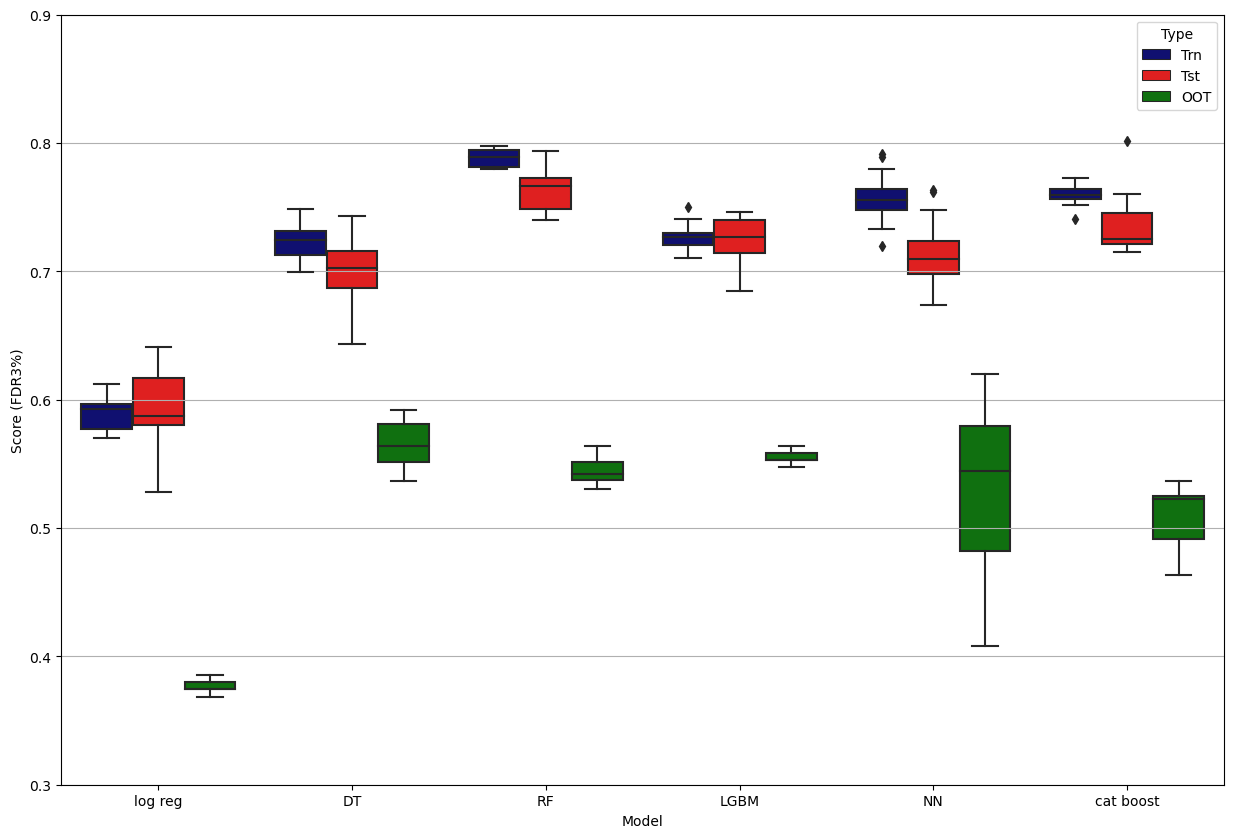

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
ax = sns.boxplot(x='Model',y='Value',hue='Type', data=df_compare, palette=['navy','r','g'])

plt.ylim(.3,.9)
plt.ylabel('Score (FDR3%)')
plt.grid(axis='y')
plt.savefig('modeling1.png')
plt.show()

In [59]:
print('duration: ', datetime.now() - start_time)

duration:  0:28:29.293444


The rest of the notebook makes the tables for your final model of choice. You need to run that final model only once (no CV). If you want you can run the below cell over and over by itself until it gives you a model you like (due to the stochastic nature of some ML algorithms, but you can't change from your best hyperparameters.

In [63]:
%%time

for niter in range(30):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

# here's where you put your final model of choice
    model = RandomForestClassifier(max_depth=7,criterion='gini',n_estimators=80,min_samples_split=60,min_samples_leaf=50,max_features=7)


    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    if(FDR3.loc[niter, 'oot'] > .56): break
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.7655986509274874 0.7282229965156795 0.547486033519553
1 0.7671232876712328 0.7331081081081081 0.553072625698324
2 0.7766497461928934 0.7301038062283737 0.547486033519553
3 0.7781569965870307 0.7448979591836735 0.553072625698324
4 0.7524590163934426 0.7555555555555555 0.5363128491620112
5 0.7686084142394822 0.7290076335877863 0.5586592178770949
6 0.7677100494233937 0.7289377289377289 0.5586592178770949
7 0.7626016260162601 0.7622641509433963 0.547486033519553
8 0.7619808306709265 0.7952755905511811 0.553072625698324
9 0.7854785478547854 0.7226277372262774 0.5586592178770949
10 0.7575250836120402 0.7624113475177305 0.553072625698324
11 0.7877280265339967 0.7111913357400722 0.553072625698324
12 0.7661927330173776 0.7449392712550608 0.553072625698324
13 0.762684124386252 0.7695167286245354 0.5418994413407822
14 0.7704918032786885 0.7333333333333333 0.5642458100558659
trn    0.768733
tst    0.743426
oot    0.551955
dtype: float64
CPU times: user 2min 23s, sys: 615 ms, total: 2min 23s
Wa

In [64]:
X_trn_eval = X_trn.copy()
X_tst_eval = X_tst.copy()
X_oot_eval = X_oot.copy()

In [65]:
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','%cg','FDR','KS','FPR']
FDR_trn = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_tst = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_oot = pd.DataFrame(np.zeros((101, 13)), columns = cols)
trn_sorted = X_trn_eval.sort_values('predicted',ascending=False)
tst_sorted = X_tst_eval.sort_values('predicted',ascending=False)
oot_sorted = X_oot_eval.sort_values('predicted',ascending=False)
bad_tot_trn = sum(X_trn_eval.loc[:, 'Fraud'])
bad_tot_tst = sum(X_tst_eval.loc[:, 'Fraud'])
bad_tot_oot = sum(X_oot_eval.loc[:, 'Fraud'])
num_tot_trn = len(X_trn_eval)
num_tot_tst = len(X_tst_eval)
num_tot_oot = len(X_oot_eval)
good_tot_trn = num_tot_trn - bad_tot_trn
good_tot_tst = num_tot_tst - bad_tot_tst
good_tot_oot = num_tot_oot - bad_tot_oot
oot_sorted.head(20)

,card_merch_total_14,card_zip3_max_14,Card_Merchdesc_count_7,Cardnum_avg_14,card_zip_max_0,card_merch_avg_0,Card_Merchnum_desc_max_0,card_zip3_med_3,Card_Merchnum_desc_avg_0,Card_Merchdesc_avg_0,predicted,Fraud
89183,9.722223,7.148446,5.448765,1.728165,8.407200,1.174277,8.420102,0.692795,1.522773,1.526026,0.912478,1
89130,9.112811,7.148446,4.927448,1.817972,8.407200,1.340228,8.420102,0.743945,1.675983,1.679549,0.912478,1
89174,9.315610,7.148446,5.188106,1.703849,8.407200,1.139221,8.420102,0.663930,1.510864,1.514094,0.912478,1
89186,9.768838,7.148446,5.709424,1.664050,8.407200,1.079135,8.420102,0.663930,1.361354,1.364278,0.912478,1
89128,7.032132,2.844300,4.666789,1.394603,1.790165,0.539276,1.794555,0.743945,0.499207,0.500372,0.910415,1
89121,6.919649,2.844300,4.406130,1.442956,1.790165,0.595229,1.794555,0.795096,0.567134,0.568437,0.910415,1
89120,6.526073,2.844300,4.145471,1.405553,1.790165,0.457145,1.794555,0.743945,0.368208,0.369105,0.910415,1
89117,6.440982,2.844300,3.884812,1.467489,1.790165,0.541938,1.794555,0.795096,0.473161,0.474272,0.910415,1
89114,6.341771,2.844300,3.624153,1.529918,1.790165,0.645879,1.794555,0.894409,0.623469,0.624888,0.909203,1
89083,5.388373,2.844300,3.363494,1.493303,-0.043396,-0.133543,-0.041364,0.795096,-0.133533,-0.133660,0.905183,1


In [66]:
for i in range(101):
    percent_rows_trn = int(round(X_trn_eval.shape[0]*0.01*i))
    percent_rows_tst = int(round(X_tst_eval.shape[0]*0.01*i))
    percent_rows_oot = int(round(X_oot_eval.shape[0]*0.01*i))
    temp_trn = trn_sorted.head(percent_rows_trn)
    temp_tst = tst_sorted.head(percent_rows_tst)
    temp_oot = oot_sorted.head(percent_rows_oot)
    num_bad_trn = sum(temp_trn.loc[:,'Fraud'])
    num_bad_tst = sum(temp_tst.loc[:,'Fraud'])
    num_bad_oot = sum(temp_oot.loc[:,'Fraud'])
    num_tot_trn = len(temp_trn)
    num_tot_tst = len(temp_tst)
    num_tot_oot = len(temp_oot)
    num_good_trn = num_tot_trn - num_bad_trn
    num_good_tst = num_tot_tst - num_bad_tst
    num_good_oot = num_tot_oot - num_bad_oot
    
    FDR_trn.loc[i, 'bin'] = i
    FDR_trn.loc[i,'#recs'] = 0
    FDR_trn.loc[i, 'tot'] = num_tot_trn
    FDR_trn.loc[i, 'cg'] = num_good_trn
    FDR_trn.loc[i, 'cb'] = num_bad_trn
    FDR_tst.loc[i, 'bin'] = i
    FDR_tst.loc[i, 'tot'] = num_tot_tst
    FDR_tst.loc[i, 'cg'] = num_good_tst
    FDR_tst.loc[i, 'cb'] = num_bad_tst
    FDR_oot.loc[i, 'bin'] = i
    FDR_oot.loc[i, 'tot'] = num_tot_oot
    FDR_oot.loc[i, 'cg'] = num_good_oot
    FDR_oot.loc[i, 'cb'] = num_bad_oot
    if i != 0:
        FDR_trn.loc[i, '#g'] = num_good_trn - FDR_trn.loc[i-1, 'cg']
        FDR_trn.loc[i, '#b'] = num_bad_trn - FDR_trn.loc[i-1, 'cb']
        FDR_trn.loc[i,'#recs'] = FDR_trn.loc[i, '#g'] + FDR_trn.loc[i, '#b']
        FDR_trn.loc[i, '%g'] = 100* (num_good_trn - FDR_trn.loc[i-1, 'cg']) / (num_tot_trn - FDR_trn.loc[i-1, 'tot'])
        FDR_trn.loc[i, '%b'] = 100 - FDR_trn.loc[i, '%g']
        FDR_trn.loc[i, '%cg'] = 100 * num_good_trn / good_tot_trn
        FDR_trn.loc[i, 'FDR'] = 100 * num_bad_trn / bad_tot_trn
        FDR_trn.loc[i, 'KS'] = FDR_trn.loc[i, 'FDR'] - FDR_trn.loc[i, '%cg']
        FDR_trn.loc[i, 'FPR'] = num_good_trn / num_bad_trn
        FDR_tst.loc[i, '#g'] = num_good_tst - FDR_tst.loc[i-1, 'cg']
        FDR_tst.loc[i, '#b'] = num_bad_tst - FDR_tst.loc[i-1, 'cb']
        FDR_tst.loc[i,'#recs'] = FDR_tst.loc[i, '#g'] + FDR_tst.loc[i, '#b']
        FDR_tst.loc[i, '%g'] = 100* (num_good_tst - FDR_tst.loc[i-1, 'cg']) / (num_tot_tst - FDR_tst.loc[i-1, 'tot'])
        FDR_tst.loc[i, '%b'] = 100 - FDR_tst.loc[i, '%g']
        FDR_tst.loc[i, '%cg'] = 100 * num_good_tst / good_tot_tst
        FDR_tst.loc[i, 'FDR'] = 100 * num_bad_tst / bad_tot_tst
        FDR_tst.loc[i, 'KS'] = FDR_tst.loc[i, 'FDR'] - FDR_tst.loc[i, '%cg']
        FDR_tst.loc[i, 'FPR'] = num_good_tst / num_bad_tst
        FDR_oot.loc[i, '#g'] = num_good_oot - FDR_oot.loc[i-1, 'cg']
        FDR_oot.loc[i, '#b'] = num_bad_oot - FDR_oot.loc[i-1, 'cb']
        FDR_oot.loc[i,'#recs'] = FDR_oot.loc[i, '#g'] + FDR_oot.loc[i, '#b']
        FDR_oot.loc[i, '%g'] = 100* (num_good_oot - FDR_oot.loc[i-1, 'cg']) / (num_tot_oot - FDR_oot.loc[i-1, 'tot'])
        FDR_oot.loc[i, '%b'] = 100 - FDR_oot.loc[i, '%g']
        FDR_oot.loc[i, '%cg'] = 100 * num_good_oot / good_tot_oot
        FDR_oot.loc[i, 'FDR'] = 100 * num_bad_oot / bad_tot_oot
        FDR_oot.loc[i, 'KS'] = FDR_oot.loc[i, 'FDR'] - FDR_oot.loc[i, '%cg']
        FDR_oot.loc[i, 'FPR'] = num_good_oot / num_bad_oot

FDR_oot

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,121.0,49.0,72.0,40.495868,59.504132,121.0,49.0,72.0,0.411143,40.223464,39.812321,0.680556
2,2.0,121.0,98.0,23.0,80.991736,19.008264,242.0,147.0,95.0,1.233428,53.072626,51.839197,1.547368
3,3.0,121.0,115.0,6.0,95.041322,4.958678,363.0,262.0,101.0,2.198355,56.424581,54.226226,2.594059
4,4.0,121.0,119.0,2.0,98.347107,1.652893,484.0,381.0,103.0,3.196845,57.541899,54.345054,3.699029
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,121.0,121.0,0.0,100.000000,0.000000,11613.0,11434.0,179.0,95.938916,100.000000,4.061084,63.877095
97,97.0,121.0,121.0,0.0,100.000000,0.000000,11734.0,11555.0,179.0,96.954187,100.000000,3.045813,64.553073
98,98.0,121.0,121.0,0.0,100.000000,0.000000,11855.0,11676.0,179.0,97.969458,100.000000,2.030542,65.229050
99,99.0,121.0,121.0,0.0,100.000000,0.000000,11976.0,11797.0,179.0,98.984729,100.000000,1.015271,65.905028


In [67]:
FDR3.to_csv('FDR3.csv')

In [68]:
FDR_trn.to_csv('FDR_trn.csv', index=False)
FDR_tst.to_csv('FDR_tst.csv', index=False)
FDR_oot.to_csv('FDR_oot.csv', index=False)

Max possible savings: 21,096,000.0


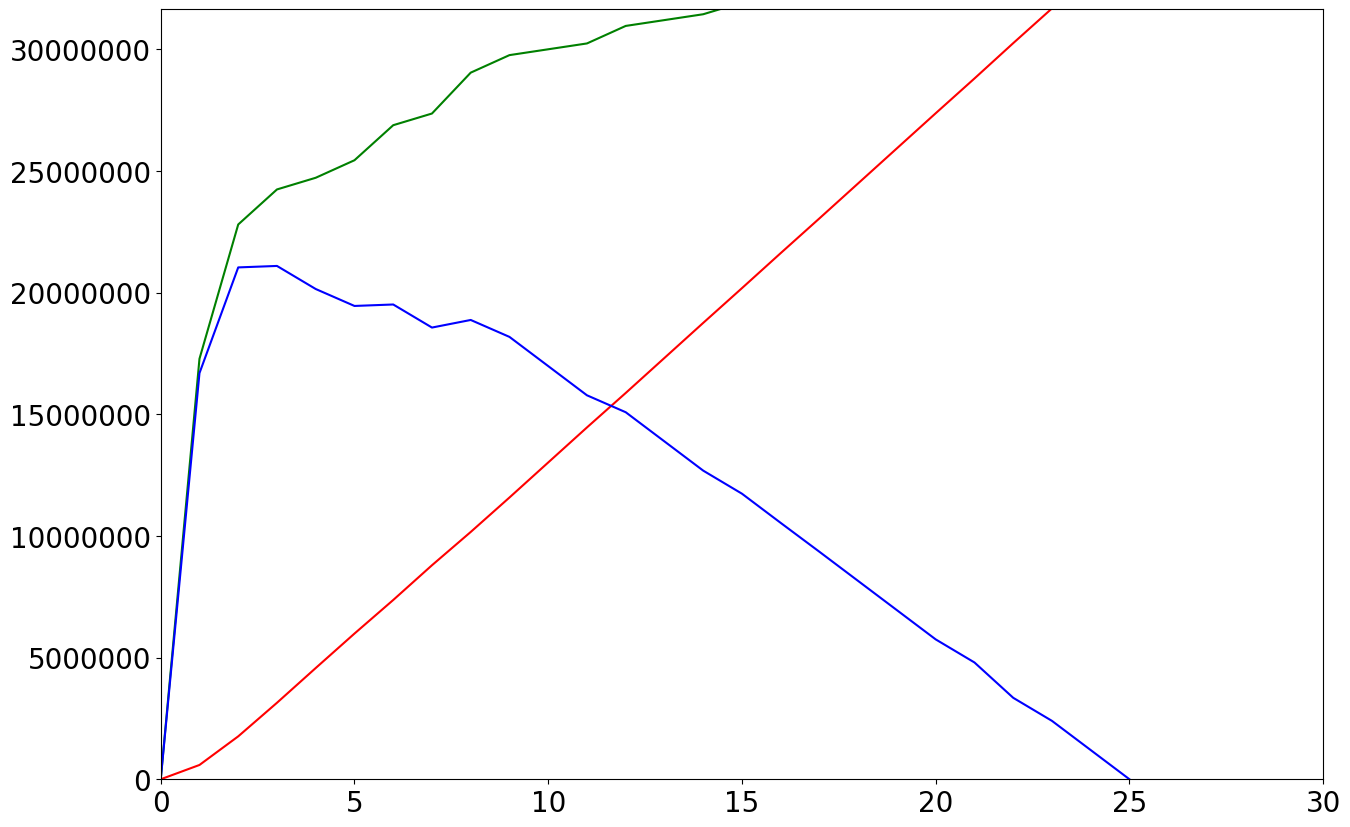

In [80]:
cost_fraud = 400
cost_fp = 20
# xmult: oot is only 2 out of 12 months, and 100,000 sample transactions out of 10 million/year
xoot = 12/2 * 10000000/100000
Financials_oot = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
for i in range(101):
    Financials_oot.loc[i, 'Fraud Savings'] = FDR_oot.loc[i, 'cb'] * cost_fraud * xoot
    Financials_oot.loc[i, 'FP Loss'] = FDR_oot.loc[i, 'cg'] * cost_fp * xoot
    Financials_oot.loc[i, 'Overall Savings'] = Financials_oot.loc[i, 'Fraud Savings'] - Financials_oot.loc[i, 'FP Loss']

max_savings = Financials_oot['Overall Savings'].max(0)
print('Max possible savings: '+'{:,}'.format(max_savings))
yupper = max_savings * 1.5
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(15,10))
plt.plot(Financials_oot['Fraud Savings'], color='green')
plt.plot(Financials_oot['FP Loss'], color='red')
plt.plot(Financials_oot['Overall Savings'], color='blue')
plt.xlim(0,30)
plt.ylim(0,yupper)
plt.ticklabel_format(style='plain')
plt.savefig('savings.png', format='png')





In [82]:
max_savings = Financials_oot['Overall Savings'].max(0)
print('Max possible savings: '+'{:,}'.format(max_savings))
yupper = max_savings * 1.5

# Find smallest cutoff close to highest savings
max_diff = 0
best_cutoff = 0
for i in range(len(Financials_oot)):
    diff = abs(Financials_oot.loc[i, 'Overall Savings'] - max_savings)
    if diff > max_diff:
        max_diff = diff
        best_cutoff = i

print('Smallest cutoff close to highest savings: {:.2f}'.format(best_cutoff/100))


Max possible savings: 21,096,000.0
Smallest cutoff close to highest savings: 1.00


Max possible savings: 21,096,000.0


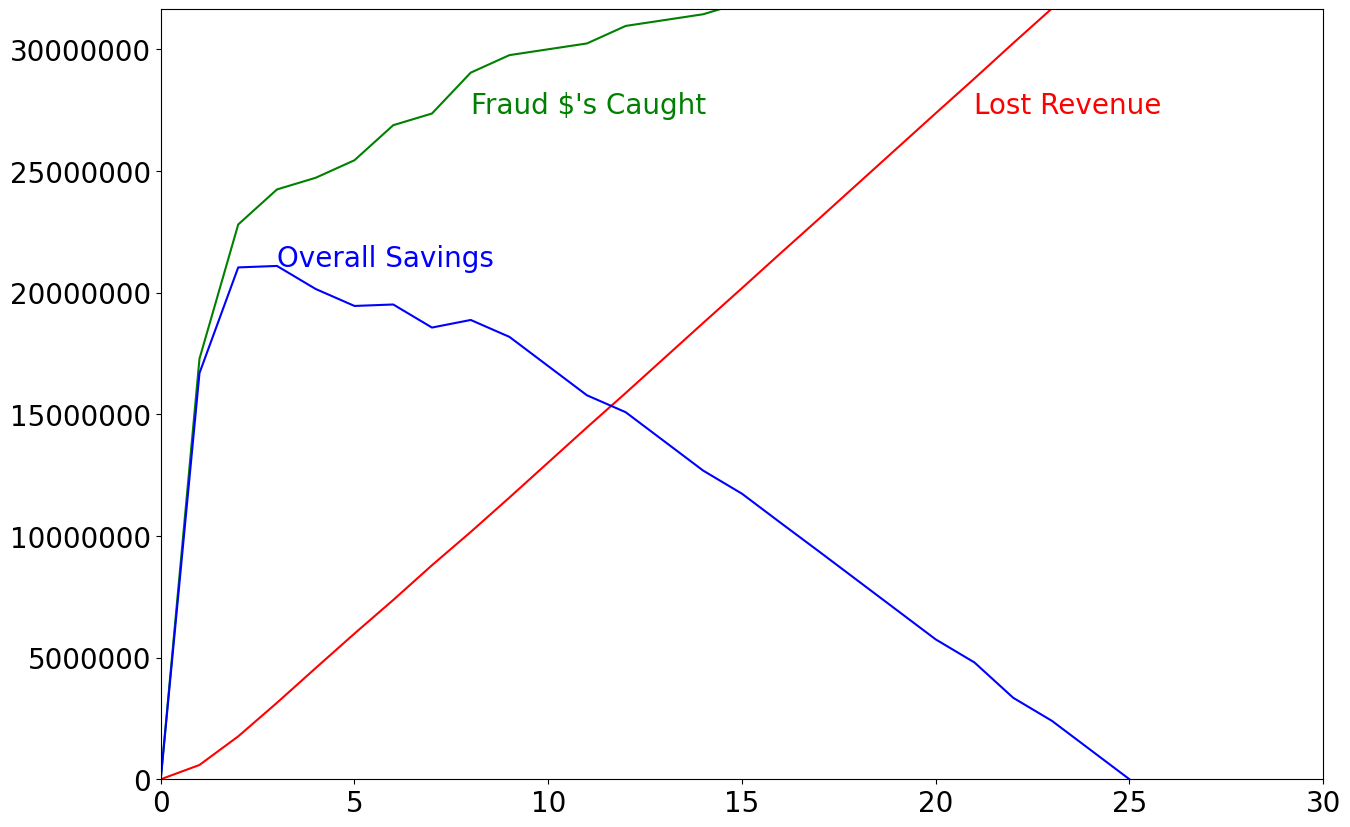

In [102]:
cost_fraud = 400
cost_fp = 20
# xmult: oot is only 2 out of 12 months, and 100,000 sample transactions out of 10 million/year
xoot = 12/2 * 10000000/100000
Financials_oot = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
for i in range(101):
    Financials_oot.loc[i, 'Fraud Savings'] = FDR_oot.loc[i, 'cb'] * cost_fraud * xoot
    Financials_oot.loc[i, 'FP Loss'] = FDR_oot.loc[i, 'cg'] * cost_fp * xoot
    Financials_oot.loc[i, 'Overall Savings'] = Financials_oot.loc[i, 'Fraud Savings'] - Financials_oot.loc[i, 'FP Loss']

max_savings = Financials_oot['Overall Savings'].max(0)
print('Max possible savings: '+'{:,}'.format(max_savings))
yupper = max_savings * 1.5
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(15,10))
plt.plot(Financials_oot['Fraud Savings'], color='green')
plt.plot(Financials_oot['FP Loss'], color='red')
plt.plot(Financials_oot['Overall Savings'], color='blue')
plt.xlim(0,30)
plt.ylim(0,yupper)
plt.ticklabel_format(style='plain')

# Add labels to the lines
plt.text(8, Financials_oot['Fraud Savings'][7], 'Fraud $\'s Caught', color='green')
plt.text(21, Financials_oot['FP Loss'][20], 'Lost Revenue', color='red')
plt.text(3, Financials_oot['Overall Savings'][3], 'Overall Savings', color='blue')

plt.savefig('savings.png', format='png')


Max possible savings: 21,096,000.0


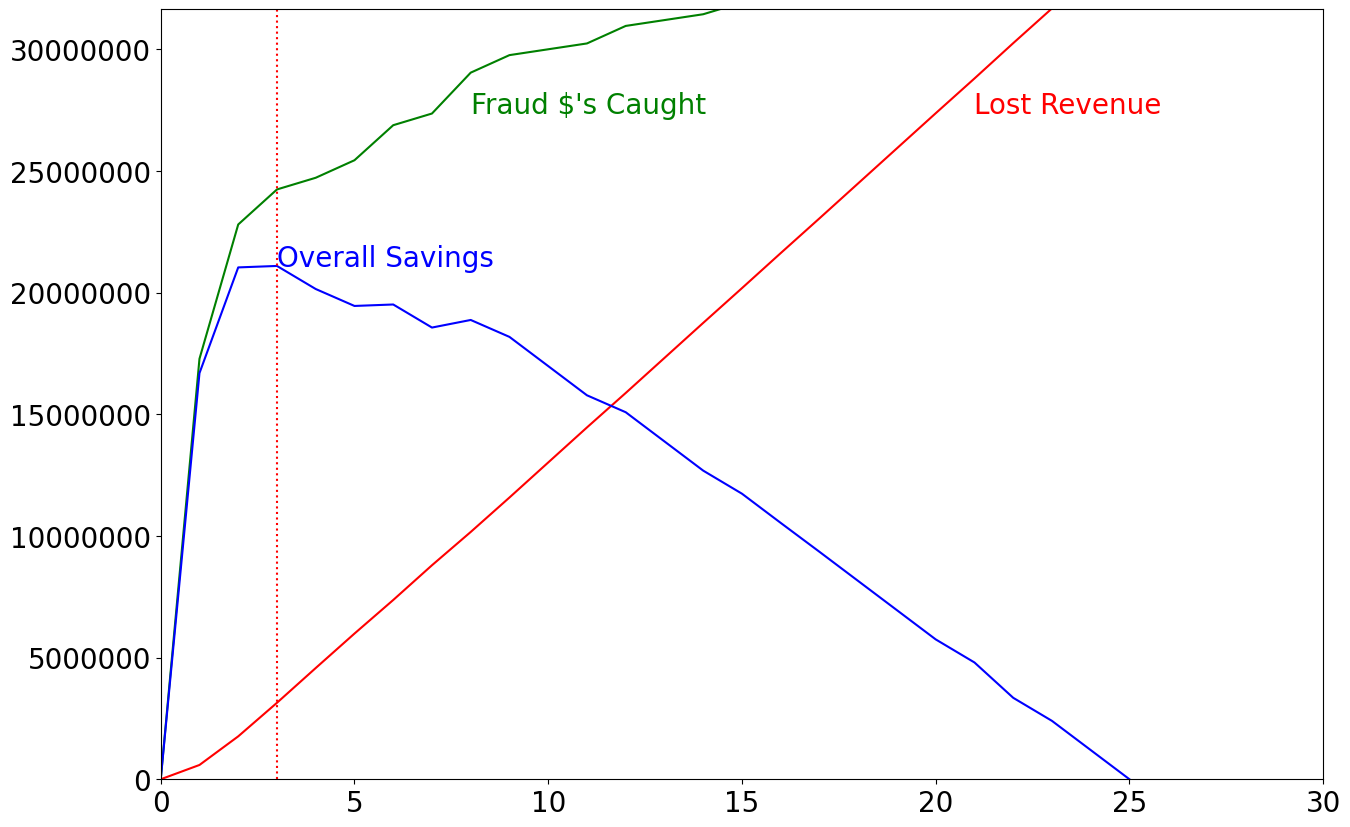

In [103]:
cost_fraud = 400
cost_fp = 20

# xmult: oot is only 2 out of 12 months, and 100,000 sample transactions out of 10 million/year
xoot = 12/2 * 10000000/100000

Financials_oot = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
for i in range(101):
    Financials_oot.loc[i, 'Fraud Savings'] = FDR_oot.loc[i, 'cb'] * cost_fraud * xoot
    Financials_oot.loc[i, 'FP Loss'] = FDR_oot.loc[i, 'cg'] * cost_fp * xoot
    Financials_oot.loc[i, 'Overall Savings'] = Financials_oot.loc[i, 'Fraud Savings'] - Financials_oot.loc[i, 'FP Loss']

max_savings = Financials_oot['Overall Savings'].max(0)
print('Max possible savings: '+'{:,}'.format(max_savings))
yupper = max_savings * 1.5

plt.rcParams.update({'font.size':20})
plt.figure(figsize=(15,10))
plt.plot(Financials_oot['Fraud Savings'], color='green')
plt.plot(Financials_oot['FP Loss'], color='red')
plt.plot(Financials_oot['Overall Savings'], color='blue')
plt.xlim(0,30)
plt.ylim(0,yupper)
plt.ticklabel_format(style='plain')

# Add labels to the lines
plt.text(8, Financials_oot['Fraud Savings'][7], 'Fraud $\'s Caught', color='green')
plt.text(21, Financials_oot['FP Loss'][20], 'Lost Revenue', color='red')
plt.text(3, Financials_oot['Overall Savings'][3], 'Overall Savings', color='blue')

# Add vertical red dotted line at x=3
plt.axvline(x=3, color='red', linestyle='dotted')

plt.savefig('savings.png', format='png')


Max possible savings: 21,096,000.0


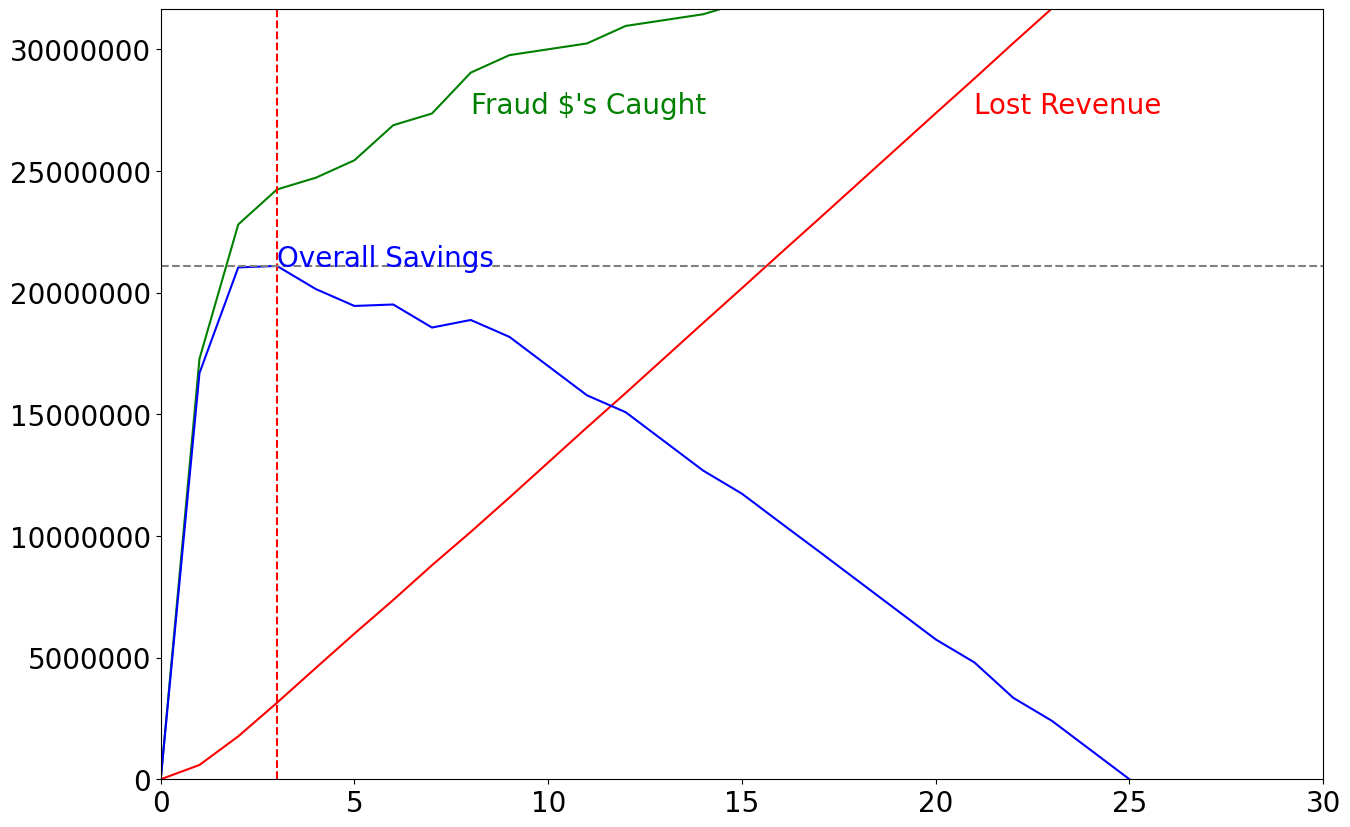

In [104]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

cost_fraud = 400
cost_fp = 20

# xmult: oot is only 2 out of 12 months, and 100,000 sample transactions out of 10 million/year
xoot = 12/2 * 10000000/100000

Financials_oot = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])

for i in range(101):
    Financials_oot.loc[i, 'Fraud Savings'] = FDR_oot.loc[i, 'cb'] * cost_fraud * xoot
    Financials_oot.loc[i, 'FP Loss'] = FDR_oot.loc[i, 'cg'] * cost_fp * xoot
    Financials_oot.loc[i, 'Overall Savings'] = Financials_oot.loc[i, 'Fraud Savings'] - Financials_oot.loc[i, 'FP Loss']

max_savings = Financials_oot['Overall Savings'].max()
max_savings_index = Financials_oot['Overall Savings'].idxmax()
print('Max possible savings: '+'{:,}'.format(max_savings))
yupper = max_savings * 1.5

plt.rcParams.update({'font.size':20})
fig, ax = plt.subplots(figsize=(15,10))

ax.plot(Financials_oot['Fraud Savings'], color='green')
ax.plot(Financials_oot['FP Loss'], color='red')
ax.plot(Financials_oot['Overall Savings'], color='blue')
ax.axvline(x=3, color='red', linestyle='--')
ax.axhline(y=max_savings, color='gray', linestyle='--')
ax.set_xlim(0,30)
ax.set_ylim(0,yupper)
ax.ticklabel_format(style='plain')

# Add labels to the lines
ax.text(8, Financials_oot['Fraud Savings'][7], 'Fraud $\'s Caught', color='green')
ax.text(21, Financials_oot['FP Loss'][20], 'Lost Revenue', color='red')
ax.text(3, Financials_oot['Overall Savings'][3], 'Overall Savings', color='blue')

plt.savefig('savings.png', format='png')


Max possible savings: 21,096,000.0


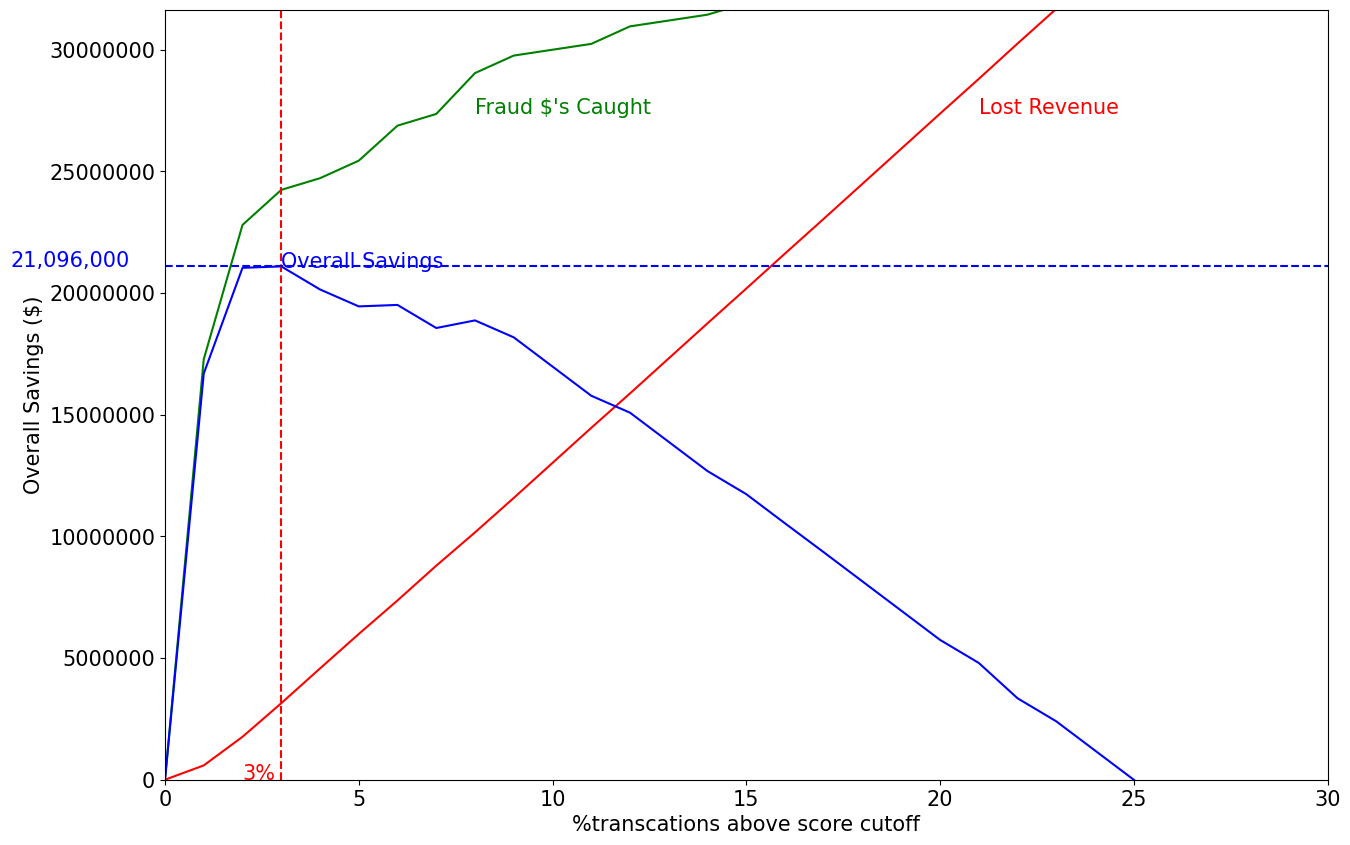

In [137]:
cost_fraud = 400
cost_fp = 20

# xmult: oot is only 2 out of 12 months, and 100,000 sample transactions out of 10 million/year
xoot = 12/2 * 10000000/100000

Financials_oot = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])

for i in range(101):
    Financials_oot.loc[i, 'Fraud Savings'] = FDR_oot.loc[i, 'cb'] * cost_fraud * xoot
    Financials_oot.loc[i, 'FP Loss'] = FDR_oot.loc[i, 'cg'] * cost_fp * xoot
    Financials_oot.loc[i, 'Overall Savings'] = Financials_oot.loc[i, 'Fraud Savings'] - Financials_oot.loc[i, 'FP Loss']

max_savings = Financials_oot['Overall Savings'].max(0)
max_savings_point = Financials_oot['Overall Savings'].idxmax()

print('Max possible savings: '+'{:,}'.format(max_savings))

yupper = max_savings * 1.5

plt.rcParams.update({'font.size':15})
plt.figure(figsize=(15,10))

plt.plot(Financials_oot['Fraud Savings'], color='green')
plt.plot(Financials_oot['FP Loss'], color='red')
plt.plot(Financials_oot['Overall Savings'], color='blue')

plt.xlim(0,30)
plt.ylim(0,yupper)
plt.ticklabel_format(style='plain')

# Add labels to the lines
plt.text(8, Financials_oot['Fraud Savings'][7], 'Fraud $\'s Caught', color='green')
plt.text(21, Financials_oot['FP Loss'][20], 'Lost Revenue', color='red')
plt.text(3, Financials_oot['Overall Savings'][2], 'Overall Savings', color='blue')

# Add vertical red dotted line at x=3
plt.axvline(x=3, linestyle='--', color='red')

# Add horizontal blue dotted line at point of max savings
plt.axhline(y=max_savings, linestyle='--', color='blue')

# Add x and y axis labels for the three lines
plt.xlabel('%transcations above score cutoff')
plt.ylabel('Overall Savings ($)')

# Add x and y values for the labels
plt.text(-4, max_savings, '{:,}'.format(int(max_savings)), color='blue')
plt.text(2., -5, '3%', color='red')

plt.savefig('final_savings.png', format='png')


In [70]:
print("duration: ", datetime.now() - start_time)

duration:  0:03:38.015536
